In [2]:
import torch
import torch.nn as nn

## Implementing a GPT Model from Scratch to generate text

In [3]:
# GPT-2 small config
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

### GPT Architecture Part 1 : DUMMY GPT Model Class

In [4]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for LayerNorm
        self.trf_blocks = nn.Sequential(
            *[DummyTransformeBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        X = tok_embeds + pos_embeds
        X = self.drop_emb(X)
        X = self.trf_blocks(X) # transformer blocks
        X = self.final_norm(X)
        logits = self.out_head(X)
        return logits


class DummyTransformeBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x


- Step 1 : Tokenization

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


- Step 2 : Create an instance of DummyGPTModel

In [6]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print(model)

DummyGPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): DummyTransformeBlock()
    (1): DummyTransformeBlock()
    (2): DummyTransformeBlock()
    (3): DummyTransformeBlock()
    (4): DummyTransformeBlock()
    (5): DummyTransformeBlock()
    (6): DummyTransformeBlock()
    (7): DummyTransformeBlock()
    (8): DummyTransformeBlock()
    (9): DummyTransformeBlock()
    (10): DummyTransformeBlock()
    (11): DummyTransformeBlock()
  )
  (final_norm): DummyLayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [7]:
print("output shape :",logits.shape)
print(logits) # 2 rows corresponding to the 2 text

output shape : torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### GPT Architecture Part 2 : Layer Normalization

In [8]:
# Example
torch.manual_seed(123)
batch_example = torch.randn(2, 5) # 2 batches , 5 inputs
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) # 5 inputs, 6 outputs
out = layer(batch_example)
print(out) 

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
# Mean, Var for each batch
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: \n", mean)
print("\nVariance: \n",var)

Mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

Variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [10]:
# Apply layer Normalization

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer output:\n", out_norm)
print("Mean: \n", mean)
print("Variance: \n",var)

Normalized layer output:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: 
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
torch.set_printoptions(sci_mode=False)
print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # small value to avoid zero division
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean: \n", mean)
print("Variance: \n",var)

Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GPT Architecture Part 3 : FeedForward NN With GELU Actization

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3)) 
        ))

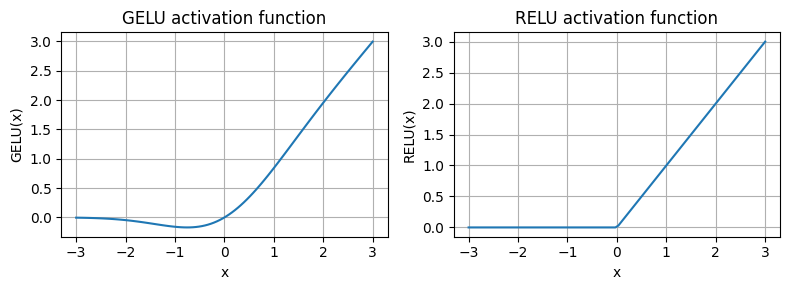

In [15]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'RELU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f'{label} activation function')
    plt.xlabel('x')
    plt.ylabel(f'{label}(x)')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']), # increase output 4 times (Expansion)
            GELU(),  # Activation 
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']) # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(x.shape)
print(out.shape)

torch.Size([2, 3, 768])
torch.Size([2, 3, 768])


### GPT Architecture Part 4 : Shourtcut Connections

In [18]:
class ExampleDeepNeuralNetwork(nn.Module):

    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # compute the output of the current layer
            layer_output = layer(x)
            
            # check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output

            else:
                x = layer_output
        return x

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([1. , 0. , -1.])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [20]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients 
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {param.grad.abs().mean().item()}')

In [21]:
print_gradients(model=model_without_shortcut, x=sample_input)

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [22]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

# solve the vanishing gradient problem
print_gradients(model=model_with_shortcut, x=sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


### GPT Architecture Part 5 : Coding Attention and Linear Layers in a Transformer
 - The building blocks : Layer Norm, GELU and Feed-Forward NN

In [23]:
# GPT-2 small config
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

In [24]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # small value to avoid zero division
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3)) 
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']), # increase output 4 times (Expansion)
            GELU(),  # Activation 
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']) # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [25]:
from modules import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcuts = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcuts(x)
        x = x + shortcut # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcuts(x)
        x = x + shortcut # Add the original input back
        
        return x

In [26]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print('Input shape:', x.shape)
print('Output shape:', output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### GPT Architecture Part 6 : Entire GPT Model Architecture Implementation

In [27]:
# GPT-2 small config
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

- Recap 

In [28]:
import torch
import torch.nn as nn
from modules import MultiHeadAttention


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for LayerNorm
        self.trf_blocks = nn.Sequential(
            *[DummyTransformeBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        X = tok_embeds + pos_embeds
        X = self.drop_emb(X)
        X = self.trf_blocks(X) # transformer blocks
        X = self.final_norm(X)
        logits = self.out_head(X)
        return logits


class DummyTransformeBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x




class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # small value to avoid zero division
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3)) 
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']), # increase output 4 times (Expansion)
            GELU(),  # Activation 
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']) # Contraction
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcuts = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcuts(x)
        x = x + shortcut # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcuts(x)
        x = x + shortcut # Add the original input back
        
        return x

- Now we gonna use all these classes to code the entire GPT Architecture

In [29]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        ) # 12 trf block

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape # seq_len = num tokens
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds # shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [30]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [31]:
model.parameters()

<generator object Module.parameters at 0x0000021658DAAF80>

In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of params: {total_params:,}') # 163M params

Total number of params: 163,009,536


In [33]:
print('Token embedding layer shape:', model.tok_emb.weight.shape)
print('Output layer shape:', model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [34]:
total_params_gp2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f'Total of trainable params: {total_params_gp2:,}') # 124M params


Total of trainable params: 124,412,160


In [35]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024*1024)
print(f'Total size of the model: {total_size_mb:.2f} MB')

Total size of the model: 621.83 MB


### GPT Architecture Part 7 : Generating Text From Output Tokens

In [36]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    for _ in range(max_new_tokens):
        # Crop current context if it exceeds the supported context size
        # Eg if LLM supports only 5 tokens, and the context size is 10
        # then only the best 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) #[batch, n_tokens , vocab_size]

        # Focus only on the last time step (last token)
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softma to get probabilities
        probas= torch.softmax(logits, dim=-1) # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # (btch, 1)

        # Append smapled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (btch, n_token+1)

    return idx

In [37]:
start_context = "Hello, I am a "
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print('encoded_tensor shape: ',encoded_tensor.shape)

encoded: [15496, 11, 314, 716, 257, 220]
encoded_tensor shape:  torch.Size([1, 6])


In [38]:
# we disable dropout since we are not training the model

model.eval() #disables random components like dropout
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M['context_length']
)
print("Output: ",out)
print("Output length: ", len(out[0]))

Output:  tensor([[15496,    11,   314,   716,   257,   220, 30387, 13585, 25265, 40975,
           588, 34845]])
Output length:  12


In [39]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text) # we are not train the model yet
# we just implemented the GPT Architecture and initilized it with initial random weights
# we need then to train this 124M params

Hello, I am a Spring Facfashion combating like wrestler


#### - Using GPT to generate text

In [40]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # Disable dropout during inference

In [41]:
# we reduce the context length of only 256 tokens, GPT-2 model used 1024 tokens
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"

tokenizer = tiktoken.get_encoding('gpt2')
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M['context_length']
)

print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you Aeiman Byeswickattributeometer inspector Normandy freezerigrate


#### - Calculating the text generation loss : cross-entropy and perplexity
- we measure what good text is

In [42]:
inputs = torch.tensor([
    [16833, 3626, 6100], # Every effort moves
    [40,     1107, 588]  # I really like
])

targets = torch.tensor([
    [3626, 6100, 345], # effort moves you
    [1107, 588, 11311] # really like chocolate
])

In [57]:
with torch.no_grad():
    logits = model(inputs)

print(logits.shape)
probas = torch.softmax(logits, dim=-1) # proba of each token in vcb
print(probas.shape) # [batch_size, num_tokens, vocab_size]
print(probas)

torch.Size([2, 3, 50257])
torch.Size([2, 3, 50257])
tensor([[[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]],

        [[    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000],
         [    0.0000,     0.0000,     0.0000,  ...,     0.0000,
              0.0000,     0.0000]]])


In [ ]:
# The index of max value for each column
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36397],
         [39619],
         [20610]],

        [[ 8615],
         [49289],
         [47105]]])


In [ ]:
# target = y_true , output = y_pred
print(f'Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}')
print(f'Outputs batch 2: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}') # random output
# the result : target =! output

Targets batch 1:  effort moves you
Outputs batch 2:  Gathering SerbianFriday


- cross-entropy loss

In [56]:

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print('Text 1:', target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print('Text 2:', target_probas_2)

Text 1: tensor([    0.0000,     0.0000,     0.0000])
Text 2: tensor([    0.0000,     0.0000,     0.0000])


In [58]:
# Merge and Compute logarithm of all token probas
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.6600, -10.7936, -11.3531, -10.0591, -11.0276, -11.3658])


In [59]:
# Claculate the average proba for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8765)


In [61]:
# Claculate the negative average proba for each token
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8765)


In [60]:
# Logits have shape [batch_size, num_tokens, vocab_size]
print('Logits shape:', logits.shape)

# Targets have shape [batch_size, num_tokens]
print('Targets shape:', targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [50]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattend logits:", logits_flat.shape)
print("Flattend targets:", targets_flat.shape)

Flattend logits: torch.Size([6, 50257])
Flattend targets: torch.Size([6])


In [51]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8765)


- Perplexity

In [52]:
# A concept related to the cross-entropy loss is the perplexity of an LLM (perp = exp(cross-entropy loss))
perplexity = torch.exp(loss)
print(perplexity)

tensor(52918.7773)


#### - Calculating the training and validation set losses

In [ ]:
with open('the-verdict.txt', mode='r') as f:
    text_data = f.read()

print(len(text_data))
print(text_data[:49]) # first 50 characters

20479
I HAD always thought Jack Gisburn rather a cheap 


In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print('Characters: ', total_characters)
print('Tokens: ', total_tokens)

# Lec27 ...

Characters:  20479
Tokens:  5145
